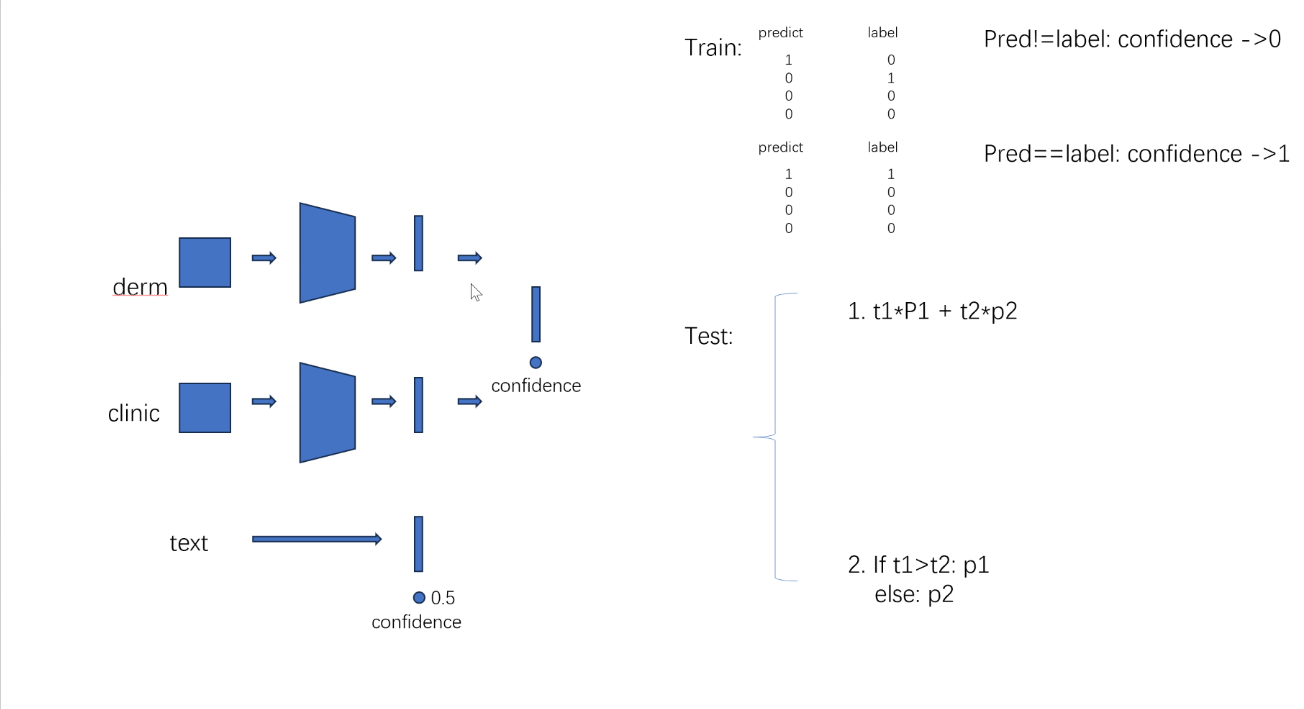

In [1]:
from utils import Logger,adjust_learning_rate,CreateLogger,create_cosine_learning_schedule,encode_test_label,set_seed
from model import Resnet_with_uncertainty#不确定度
from dependency import *
from torch import optim
from torchcontrib.optim import SWA
from dataloader import generate_dataloader
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import mean_squared_error # 均方误差

In [2]:
def train(net, train_dataloader, model_name):
    net.set_mode("train")
    train_loss = 0
    train_dia_acc = 0
    train_sps_acc = 0
    for index,(clinic_image,derm_image,meta_data,label) in enumerate(train_dataloader):
        opt.zero_grad()
        
        clinic_image = clinic_image.cuda()
        derm_image = derm_image.cuda()
        #meta_data = meta_data.cuda()
        
        #Diagnostic label
        diagnosis_label = label[0].long().cuda()
        #Seven-Point Checklist labels
        pn_label = label[1].long().cuda()
        str_label = label[2].long().cuda()
        pig_label = label[3].long().cuda()
        rs_label = label[4].long().cuda()
        dag_label = label[5].long().cuda()
        bwv_label = label[6].long().cuda()
        vs_label = label[7].long().cuda()
        #uncertainty
        
        [   (logit_diagnosis_clic,logit_pn_clic,logit_str_clic,logit_pig_clic,logit_rs_clic,logit_dag_clic,logit_bwv_clic,logit_vs_clic,logit_uncertainty_clic),
            (logit_diagnosis_derm,logit_pn_derm,logit_str_derm,logit_pig_derm,logit_rs_derm,logit_dag_derm,logit_bwv_derm,logit_vs_derm,logit_uncertainty_derm),
            (logit_diagnosis, logit_pn, logit_str, logit_pig, logit_rs, logit_dag, logit_bwv,logit_vs,logit_uncertainty),
            (x_clic_cos,x_derm_cos)] = net((clinic_image,derm_image))
        
        prediction1 = torch.argmax(torch.nn.Softmax(dim=1)(logit_diagnosis_clic), dim = 1)
            
        prediction2 = torch.argmax(torch.nn.Softmax(dim=1)(logit_pn_clic), dim = 1)

        prediction3 = torch.argmax(torch.nn.Softmax(dim=1)(logit_str_clic), dim = 1)

        prediction4 = torch.argmax(torch.nn.Softmax(dim=1)(logit_pig_clic), dim = 1)

        prediction5 = torch.argmax(torch.nn.Softmax(dim=1)(logit_rs_clic), dim = 1)

        prediction6 = torch.argmax(torch.nn.Softmax(dim=1)(logit_dag_clic), dim = 1)

        prediction7 = torch.argmax(torch.nn.Softmax(dim=1)(logit_bwv_clic), dim = 1)

        prediction8 = torch.argmax(torch.nn.Softmax(dim=1)(logit_vs_clic), dim = 1)
        
        diagnosis_label_t = diagnosis_label.unsqueeze(0)
        pn_label_t = pn_label.unsqueeze(0)
        str_label_t = str_label.unsqueeze(0)
        pig_label_t = pig_label.unsqueeze(0)
        rs_label_t = rs_label.unsqueeze(0)
        dag_label_t = dag_label.unsqueeze(0)
        bwv_label_t = bwv_label.unsqueeze(0)
        vs_label_t = vs_label.unsqueeze(0)
        
        prediction1 = prediction1.unsqueeze(0)
        prediction2 = prediction2.unsqueeze(0)
        prediction3 = prediction3.unsqueeze(0)
        prediction4 = prediction4.unsqueeze(0)
        prediction5 = prediction5.unsqueeze(0)
        prediction6 = prediction6.unsqueeze(0)
        prediction7 = prediction7.unsqueeze(0)
        prediction8 = prediction8.unsqueeze(0)
        
        #concatenate tensor
        pn_label_t = np.array(pn_label_t.cpu(),dtype="int")
        str_label_t = np.array(str_label_t.cpu(),dtype="int")
        pig_label_t = np.array(pig_label_t.cpu(),dtype="int")
        rs_label_t = np.array(rs_label_t.cpu(),dtype="int")
        dag_label_t = np.array(dag_label_t.cpu(),dtype="int")
        bwv_label_t = np.array(bwv_label_t.cpu(),dtype="int")
        vs_label_t = np.array(vs_label_t.cpu(),dtype="int")
        diagnosis_label_t = np.array(diagnosis_label_t.cpu(),dtype="int")
        
        #print("prediction1.size:",prediction1.size())
        prediction1 = np.array(prediction1.cpu(),dtype="int")
        prediction2 = np.array(prediction2.cpu(),dtype="int")
        prediction3 = np.array(prediction3.cpu(),dtype="int")
        prediction4 = np.array(prediction4.cpu(),dtype="int")
        prediction5 = np.array(prediction5.cpu(),dtype="int")
        prediction6 = np.array(prediction6.cpu(),dtype="int")
        prediction7 = np.array(prediction7.cpu(),dtype="int")
        prediction8 = np.array(prediction8.cpu(),dtype="int")
        
        t = np.hstack((diagnosis_label_t.T,pn_label_t.T))
        t = np.hstack((t,str_label_t.T))
        t = np.hstack((t,pig_label_t.T))
        t = np.hstack((t,rs_label_t.T))
        t = np.hstack((t,dag_label_t.T))
        t = np.hstack((t,bwv_label_t.T))
        t = np.hstack((t,vs_label_t.T))
        t = torch.tensor(t)
        p = np.hstack((prediction1.T,prediction2.T))
        p = np.hstack((p,prediction3.T))
        p = np.hstack((p,prediction4.T))
        p = np.hstack((p,prediction5.T))
        p = np.hstack((p,prediction6.T))
        p = np.hstack((p,prediction7.T))
        p = np.hstack((p,prediction8.T))
        p = torch.tensor(p)
        #print("t:",t)
        #print("p:",p)
        certainty_b = (t == p).long()
        #print("certainty_b:",certainty_b)
        #print("certainty_b.size:",certainty_b.size())
        certainty_ones = torch.tensor(np.ones(certainty_b.size()))
        #print("certainty_ones:",certainty_ones)
        #print("certainty_ones.size:",certainty_ones.size())
        uncertainty_label_clic = []
        for i in range(certainty_ones.size(0)):
            mean_squared_error_tmp = mean_squared_error(certainty_ones[i,:],certainty_b[i,:])
            if mean_squared_error_tmp >=0.6:
                mean_squared_error_tmp = 1
            else:
                mean_squared_error_tmp = 0
            uncertainty_label_clic.append([mean_squared_error_tmp]) # bigger uncertainty, bigger MSE, means the prediction is less accurate. 
        uncertainty_label_clic = torch.tensor(uncertainty_label_clic)
        #print("uncertainty_label_clic:",uncertainty_label_clic)
        
        #uncertainty
        uncertainty_label_clic = uncertainty_label_clic.float().cuda()
    
        #print("uncertainty_label_clic:",uncertainty_label_clic)
        #print("logit_uncertainty_clic:",logit_uncertainty_clic)
        
        #print("diagnosis_label:",diagnosis_label)
        #print("logit_diagnosis_clic:",logit_diagnosis_clic)
        #print("net.criterion(logit_diagnosis_clic, diagnosis_label):",net.criterion(logit_diagnosis_clic, diagnosis_label))
        
        loss_clic = torch.div(
          net.criterion(logit_diagnosis_clic, diagnosis_label)
        + net.criterion(logit_pn_clic, pn_label)
        + net.criterion(logit_str_clic, str_label)
        + net.criterion(logit_pig_clic, pig_label)
        + net.criterion(logit_rs_clic, rs_label)
        + net.criterion(logit_dag_clic, dag_label)
        + net.criterion(logit_bwv_clic, bwv_label)
        + net.criterion(logit_vs_clic, vs_label)
        + net.criterion_MSE(logit_uncertainty_clic,uncertainty_label_clic), 9)
        #print("loss_clic:",loss_clic)
        
        #derm
        prediction1 = torch.argmax(torch.nn.Softmax(dim=1)(logit_diagnosis_derm),dim = 1)
        
        prediction2 = torch.argmax(torch.nn.Softmax(dim=1)(logit_pn_derm),dim = 1)

        prediction3 = torch.argmax(torch.nn.Softmax(dim=1)(logit_str_derm),dim = 1)

        prediction4 = torch.argmax(torch.nn.Softmax(dim=1)(logit_pig_derm), dim = 1)

        prediction5 =torch.argmax(torch.nn.Softmax(dim=1)(logit_rs_derm), dim = 1)

        prediction6 = torch.argmax(torch.nn.Softmax(dim=1)(logit_dag_derm), dim = 1)

        prediction7 = torch.argmax(torch.nn.Softmax(dim=1)(logit_bwv_derm), dim = 1)

        prediction8 = torch.argmax(torch.nn.Softmax(dim=1)(logit_vs_clic), dim = 1)

        prediction1 = prediction1.unsqueeze(0)
        prediction2 = prediction2.unsqueeze(0)
        prediction3 = prediction3.unsqueeze(0)
        prediction4 = prediction4.unsqueeze(0)
        prediction5 = prediction5.unsqueeze(0)
        prediction6 = prediction6.unsqueeze(0)
        prediction7 = prediction7.unsqueeze(0)
        prediction8 = prediction8.unsqueeze(0)
        prediction1 = np.array(prediction1.cpu(),dtype="int")
        prediction2 = np.array(prediction2.cpu(),dtype="int")
        prediction3 = np.array(prediction3.cpu(),dtype="int")
        prediction4 = np.array(prediction4.cpu(),dtype="int")
        prediction5 = np.array(prediction5.cpu(),dtype="int")
        prediction6 = np.array(prediction6.cpu(),dtype="int")
        prediction7 = np.array(prediction7.cpu(),dtype="int")
        prediction8 = np.array(prediction8.cpu(),dtype="int")
        
        p = np.hstack((prediction1.T,prediction2.T))
        p = np.hstack((p,prediction3.T))
        p = np.hstack((p,prediction4.T))
        p = np.hstack((p,prediction5.T))
        p = np.hstack((p,prediction6.T))
        p = np.hstack((p,prediction7.T))
        p = np.hstack((p,prediction8.T))
        p = torch.tensor(p)
        
        certainty_b = (t == p).long()
        certainty_ones = torch.tensor(np.ones(certainty_b.size()))
        uncertainty_label_derm = []
        for i in range(certainty_ones.size(0)):
            mean_squared_error_tmp = mean_squared_error(certainty_ones[i,:],certainty_b[i,:])
            if mean_squared_error_tmp >=0.6:
                mean_squared_error_tmp = 1
            else:
                mean_squared_error_tmp = 0
            uncertainty_label_derm.append([mean_squared_error_tmp]) # bigger uncertainty, bigger MSE, means the prediction is less accurate. 
        uncertainty_label_derm = torch.tensor(uncertainty_label_derm)
        #uncertainty
        uncertainty_label_derm = uncertainty_label_derm.float().cuda()
        
        loss_derm = torch.div(
          net.criterion(logit_diagnosis_derm, diagnosis_label)
        + net.criterion(logit_pn_derm, pn_label)
        + net.criterion(logit_str_derm, str_label)
        + net.criterion(logit_pig_derm, pig_label)
        + net.criterion(logit_rs_derm, rs_label)
        + net.criterion(logit_dag_derm, dag_label)
        + net.criterion(logit_bwv_derm, bwv_label)
        + net.criterion(logit_vs_derm, vs_label)
        + net.criterion_MSE(logit_uncertainty_derm,uncertainty_label_derm), 9)
        
        #concat
        prediction1 = torch.argmax(torch.nn.Softmax(dim=1)(logit_diagnosis),dim = 1)
        
        prediction2 = torch.argmax(torch.nn.Softmax(dim=1)(logit_pn),dim = 1)

        prediction3 = torch.argmax(torch.nn.Softmax(dim=1)(logit_str),dim = 1)

        prediction4 = torch.argmax(torch.nn.Softmax(dim=1)(logit_pig), dim = 1)
    
        prediction5 = torch.argmax(torch.nn.Softmax(dim=1)(logit_rs),dim = 1)

        prediction6 = torch.argmax(torch.nn.Softmax(dim=1)(logit_dag),dim = 1)
        
        prediction7 = torch.argmax(torch.nn.Softmax(dim=1)(logit_bwv),dim = 1)
        
        prediction8 = torch.argmax(torch.nn.Softmax(dim=1)(logit_vs),dim = 1)
        
        prediction1 = prediction1.unsqueeze(0)
        prediction2 = prediction2.unsqueeze(0)
        prediction3 = prediction3.unsqueeze(0)
        prediction4 = prediction4.unsqueeze(0)
        prediction5 = prediction5.unsqueeze(0)
        prediction6 = prediction6.unsqueeze(0)
        prediction7 = prediction7.unsqueeze(0)
        prediction8 = prediction8.unsqueeze(0)
        prediction1 = np.array(prediction1.cpu(),dtype="int")
        prediction2 = np.array(prediction2.cpu(),dtype="int")
        prediction3 = np.array(prediction3.cpu(),dtype="int")
        prediction4 = np.array(prediction4.cpu(),dtype="int")
        prediction5 = np.array(prediction5.cpu(),dtype="int")
        prediction6 = np.array(prediction6.cpu(),dtype="int")
        prediction7 = np.array(prediction7.cpu(),dtype="int")
        prediction8 = np.array(prediction8.cpu(),dtype="int")
        
        p = np.hstack((prediction1.T,prediction2.T))
        p = np.hstack((p,prediction3.T))
        p = np.hstack((p,prediction4.T))
        p = np.hstack((p,prediction5.T))
        p = np.hstack((p,prediction6.T))
        p = np.hstack((p,prediction7.T))
        p = np.hstack((p,prediction8.T))
        p = torch.tensor(p)
        
        certainty_b = (t == p).long()
        certainty_ones = torch.tensor(np.ones(certainty_b.size()))
        uncertainty_label = []
        for i in range(certainty_ones.size(0)):
            mean_squared_error_tmp = mean_squared_error(certainty_ones[i,:],certainty_b[i,:])
            if mean_squared_error_tmp >=0.6:
                mean_squared_error_tmp = 1
            else:
                mean_squared_error_tmp = 0
            uncertainty_label.append([mean_squared_error_tmp]) # bigger uncertainty, bigger MSE, means the prediction is less accurate. 
        uncertainty_label = torch.tensor(uncertainty_label)
        #uncertainty
        uncertainty_label = uncertainty_label.float().cuda()
        
        loss_concat = torch.div(
          net.criterion(logit_diagnosis, diagnosis_label)
        + net.criterion(logit_pn, pn_label)
        + net.criterion(logit_str, str_label)
        + net.criterion(logit_pig, pig_label)
        + net.criterion(logit_rs, rs_label)
        + net.criterion(logit_dag, dag_label)
        + net.criterion(logit_bwv, bwv_label)
        + net.criterion(logit_vs, vs_label)
        + net.criterion_MSE(logit_uncertainty,uncertainty_label), 9)
        
        x_clic_cos = x_clic_cos.float()
        x_derm_cos = x_derm_cos.float()
        criterion = nn.CosineEmbeddingLoss()
        Tar = np.ones((x_clic_cos.size(0)))
        Tar = torch.Tensor(Tar).cuda()
        loss_cos = criterion(x_clic_cos, x_derm_cos,Tar)
        loss = loss_concat*0.8 + loss_cos*0.2    #(0.1,0.2)
        #loss = loss_concat*0.9 + loss_cos*0.1
        #loss = loss_clic*0.5 + loss_derm*0.5
        
        #print("1:",net.metric(logit_diagnosis_fusion, diagnosis_label))
        dia_acc_all = torch.div(net.metric(logit_diagnosis,diagnosis_label),int(clinic_image.size(0)))
        sps_acc_all = torch.div(  net.metric(logit_pn,pn_label)
                                + net.metric(logit_str,str_label)
                                + net.metric(logit_pig,pig_label)
                                + net.metric(logit_rs,rs_label)
                                + net.metric(logit_dag,dag_label)
                                + net.metric(logit_bwv,bwv_label)
                                + net.metric(logit_vs,vs_label),int(7 * clinic_image.size(0)))
        loss.backward()
        opt.step()

        train_loss += loss.item()
        train_dia_acc += dia_acc_all.item()
        train_sps_acc += sps_acc_all.item()

    train_loss = train_loss / (index + 1) # Because the index start with the value 0f zero
    train_dia_acc = train_dia_acc / (index + 1)
    train_sps_acc = train_sps_acc / (index + 1)

    return train_loss,train_dia_acc,train_sps_acc

In [3]:
def validation(net,val_dataloader,model_name):
    net.set_mode('valid')
    val_loss = 0
    val_dia_acc = 0
    vaL_sps_acc = 0
    for index, (clinic_image, derm_image, meta_data, label) in enumerate(val_dataloader):

        clinic_image = clinic_image.cuda()
        derm_image   = derm_image.cuda()
        #meta_data    = meta_data.cuda()

        diagnosis_label = label[0].long().cuda()
        pn_label = label[1].long().cuda()
        str_label = label[2].long().cuda()
        pig_label = label[3].long().cuda()
        rs_label = label[4].long().cuda()
        dag_label = label[5].long().cuda()
        bwv_label = label[6].long().cuda()
        vs_label = label[7].long().cuda()
        

        with torch.no_grad():

            [   (logit_diagnosis_clic,logit_pn_clic,logit_str_clic,logit_pig_clic,logit_rs_clic,logit_dag_clic,logit_bwv_clic,logit_vs_clic,logit_uncertainty_clic),
            (logit_diagnosis_derm,logit_pn_derm,logit_str_derm,logit_pig_derm,logit_rs_derm,logit_dag_derm,logit_bwv_derm,logit_vs_derm,logit_uncertainty_derm),
            (logit_diagnosis, logit_pn, logit_str, logit_pig, logit_rs, logit_dag, logit_bwv,logit_vs,logit_uncertainty),
            (x_clic_cos,x_derm_cos)] = net((clinic_image,derm_image))
            
            prediction1 = torch.argmax(torch.nn.Softmax(dim=1)(logit_diagnosis_clic), dim = 1)
            
            prediction2 = torch.argmax(torch.nn.Softmax(dim=1)(logit_pn_clic), dim = 1)

            prediction3 = torch.argmax(torch.nn.Softmax(dim=1)(logit_str_clic), dim = 1)

            prediction4 = torch.argmax(torch.nn.Softmax(dim=1)(logit_pig_clic), dim = 1)

            prediction5 = torch.argmax(torch.nn.Softmax(dim=1)(logit_rs_clic), dim = 1)

            prediction6 = torch.argmax(torch.nn.Softmax(dim=1)(logit_dag_clic), dim = 1)

            prediction7 = torch.argmax(torch.nn.Softmax(dim=1)(logit_bwv_clic), dim = 1)

            prediction8 = torch.argmax(torch.nn.Softmax(dim=1)(logit_vs_clic), dim = 1)
        
            diagnosis_label_t = diagnosis_label.unsqueeze(0)
            pn_label_t = pn_label.unsqueeze(0)
            str_label_t = str_label.unsqueeze(0)
            pig_label_t = pig_label.unsqueeze(0)
            rs_label_t = rs_label.unsqueeze(0)
            dag_label_t = dag_label.unsqueeze(0)
            bwv_label_t = bwv_label.unsqueeze(0)
            vs_label_t = vs_label.unsqueeze(0)
        
            prediction1 = prediction1.unsqueeze(0)
            prediction2 = prediction2.unsqueeze(0)
            prediction3 = prediction3.unsqueeze(0)
            prediction4 = prediction4.unsqueeze(0)
            prediction5 = prediction5.unsqueeze(0)
            prediction6 = prediction6.unsqueeze(0)
            prediction7 = prediction7.unsqueeze(0)
            prediction8 = prediction8.unsqueeze(0)
        
            #concatenate tensor
            pn_label_t = np.array(pn_label_t.cpu(),dtype="int")
            str_label_t = np.array(str_label_t.cpu(),dtype="int")
            pig_label_t = np.array(pig_label_t.cpu(),dtype="int")
            rs_label_t = np.array(rs_label_t.cpu(),dtype="int")
            dag_label_t = np.array(dag_label_t.cpu(),dtype="int")
            bwv_label_t = np.array(bwv_label_t.cpu(),dtype="int")
            vs_label_t = np.array(vs_label_t.cpu(),dtype="int")
            diagnosis_label_t = np.array(diagnosis_label_t.cpu(),dtype="int")
        
            prediction1 = np.array(prediction1.cpu(),dtype="int")
            prediction2 = np.array(prediction2.cpu(),dtype="int")
            prediction3 = np.array(prediction3.cpu(),dtype="int")
            prediction4 = np.array(prediction4.cpu(),dtype="int")
            prediction5 = np.array(prediction5.cpu(),dtype="int")
            prediction6 = np.array(prediction6.cpu(),dtype="int")
            prediction7 = np.array(prediction7.cpu(),dtype="int")
            prediction8 = np.array(prediction8.cpu(),dtype="int")
        
            t = np.hstack((diagnosis_label_t.T,pn_label_t.T))
            t = np.hstack((t,str_label_t.T))
            t = np.hstack((t,pig_label_t.T))
            t = np.hstack((t,rs_label_t.T))
            t = np.hstack((t,dag_label_t.T))
            t = np.hstack((t,bwv_label_t.T))
            t = np.hstack((t,vs_label_t.T))
            t = torch.tensor(t)
            p = np.hstack((prediction1.T,prediction2.T))
            p = np.hstack((p,prediction3.T))
            p = np.hstack((p,prediction4.T))
            p = np.hstack((p,prediction5.T))
            p = np.hstack((p,prediction6.T))
            p = np.hstack((p,prediction7.T))
            p = np.hstack((p,prediction8.T))
            p = torch.tensor(p)
            certainty_b = (t == p).long()
            certainty_ones = torch.tensor(np.ones(certainty_b.size()))
            uncertainty_label_clic = []
            for i in range(certainty_ones.size(0)):
                mean_squared_error_tmp = mean_squared_error(certainty_ones[i,:],certainty_b[i,:])
                if mean_squared_error_tmp >=0.6:
                    mean_squared_error_tmp = 1
                else:
                    mean_squared_error_tmp = 0
                uncertainty_label_clic.append([mean_squared_error_tmp]) # bigger uncertainty, bigger MSE, means the prediction is less accurate. 
            uncertainty_label_clic = torch.tensor(uncertainty_label_clic)
        
            #uncertainty
            uncertainty_label_clic = uncertainty_label_clic.float().cuda()    
        
            loss_clic = torch.div(
              net.criterion(logit_diagnosis_clic, diagnosis_label)
            + net.criterion(logit_pn_clic, pn_label)
            + net.criterion(logit_str_clic, str_label)
            + net.criterion(logit_pig_clic, pig_label)
            + net.criterion(logit_rs_clic, rs_label)
            + net.criterion(logit_dag_clic, dag_label)
            + net.criterion(logit_bwv_clic, bwv_label)
            + net.criterion(logit_vs_clic, vs_label)
            + net.criterion_MSE(logit_uncertainty_clic,uncertainty_label_clic), 9)
        
            #derm
            prediction1 = torch.argmax(torch.nn.Softmax(dim=1)(logit_diagnosis_derm), dim = 1)
        
            prediction2 = torch.argmax(torch.nn.Softmax(dim=1)(logit_pn_derm), dim = 1)

            prediction3 = torch.argmax(torch.nn.Softmax(dim=1)(logit_str_derm), dim = 1)

            prediction4 = torch.argmax(torch.nn.Softmax(dim=1)(logit_pig_derm), dim = 1)

            prediction5 = torch.argmax(torch.nn.Softmax(dim=1)(logit_rs_derm), dim = 1)

            prediction6 = torch.argmax(torch.nn.Softmax(dim=1)(logit_dag_derm), dim = 1)
    
            prediction7 = torch.argmax(torch.nn.Softmax(dim=1)(logit_bwv_derm), dim = 1)

            prediction8 = torch.argmax(torch.nn.Softmax(dim=1)(logit_vs_clic), dim = 1)

            prediction1 = prediction1.unsqueeze(0)
            prediction2 = prediction2.unsqueeze(0)
            prediction3 = prediction3.unsqueeze(0)
            prediction4 = prediction4.unsqueeze(0)
            prediction5 = prediction5.unsqueeze(0)
            prediction6 = prediction6.unsqueeze(0)
            prediction7 = prediction7.unsqueeze(0)
            prediction8 = prediction8.unsqueeze(0)
            prediction1 = np.array(prediction1.cpu(),dtype="int")
            prediction2 = np.array(prediction2.cpu(),dtype="int")
            prediction3 = np.array(prediction3.cpu(),dtype="int")
            prediction4 = np.array(prediction4.cpu(),dtype="int")
            prediction5 = np.array(prediction5.cpu(),dtype="int")
            prediction6 = np.array(prediction6.cpu(),dtype="int")
            prediction7 = np.array(prediction7.cpu(),dtype="int")
            prediction8 = np.array(prediction8.cpu(),dtype="int")
        
            p = np.hstack((prediction1.T,prediction2.T))
            p = np.hstack((p,prediction3.T))
            p = np.hstack((p,prediction4.T))
            p = np.hstack((p,prediction5.T))
            p = np.hstack((p,prediction6.T))
            p = np.hstack((p,prediction7.T))
            p = np.hstack((p,prediction8.T))
            p = torch.tensor(p)
        
            certainty_b = (t == p).long()
            certainty_ones = torch.tensor(np.ones(certainty_b.size()))
            uncertainty_label_derm = []
            for i in range(certainty_ones.size(0)):
                mean_squared_error_tmp = mean_squared_error(certainty_ones[i,:],certainty_b[i,:])
                if mean_squared_error_tmp >=0.6:
                    mean_squared_error_tmp = 1
                else:
                    mean_squared_error_tmp = 0
                uncertainty_label_derm.append([mean_squared_error_tmp]) # bigger uncertainty, bigger MSE, means the prediction is less accurate. 
            uncertainty_label_derm = torch.tensor(uncertainty_label_derm)
            #uncertainty
            uncertainty_label_derm = uncertainty_label_derm.float().cuda()
        
            loss_derm = torch.div(
              net.criterion(logit_diagnosis_derm, diagnosis_label)
            + net.criterion(logit_pn_derm, pn_label)
            + net.criterion(logit_str_derm, str_label)
            + net.criterion(logit_pig_derm, pig_label)
            + net.criterion(logit_rs_derm, rs_label)
            + net.criterion(logit_dag_derm, dag_label)
            + net.criterion(logit_bwv_derm, bwv_label)
            + net.criterion(logit_vs_derm, vs_label)
            + net.criterion_MSE(logit_uncertainty_derm,uncertainty_label_derm), 9)

            #concat
            prediction1 = torch.argmax(torch.nn.Softmax(dim=1)(logit_diagnosis), dim = 1)

            prediction2 = torch.argmax(torch.nn.Softmax(dim=1)(logit_pn), dim = 1)

            prediction3 = torch.argmax(torch.nn.Softmax(dim=1)(logit_str), dim = 1)

            prediction4 = torch.argmax(torch.nn.Softmax(dim=1)(logit_pig), dim = 1)
    
            prediction5 = torch.argmax(torch.nn.Softmax(dim=1)(logit_rs), dim = 1)

            prediction6 = torch.argmax(torch.nn.Softmax(dim=1)(logit_dag), dim = 1)
        
            prediction7 = torch.argmax(torch.nn.Softmax(dim=1)(logit_bwv), dim = 1)
        
            prediction8 = torch.argmax(torch.nn.Softmax(dim=1)(logit_vs), dim = 1)
        
            prediction1 = prediction1.unsqueeze(0)
            prediction2 = prediction2.unsqueeze(0)
            prediction3 = prediction3.unsqueeze(0)
            prediction4 = prediction4.unsqueeze(0)
            prediction5 = prediction5.unsqueeze(0)
            prediction6 = prediction6.unsqueeze(0)
            prediction7 = prediction7.unsqueeze(0)
            prediction8 = prediction8.unsqueeze(0)
            prediction1 = np.array(prediction1.cpu(),dtype="int")
            prediction2 = np.array(prediction2.cpu(),dtype="int")
            prediction3 = np.array(prediction3.cpu(),dtype="int")
            prediction4 = np.array(prediction4.cpu(),dtype="int")
            prediction5 = np.array(prediction5.cpu(),dtype="int")
            prediction6 = np.array(prediction6.cpu(),dtype="int")
            prediction7 = np.array(prediction7.cpu(),dtype="int")
            prediction8 = np.array(prediction8.cpu(),dtype="int")
        
            p = np.hstack((prediction1.T,prediction2.T))
            p = np.hstack((p,prediction3.T))
            p = np.hstack((p,prediction4.T))
            p = np.hstack((p,prediction5.T))
            p = np.hstack((p,prediction6.T))
            p = np.hstack((p,prediction7.T))
            p = np.hstack((p,prediction8.T))
            p = torch.tensor(p)
        
            certainty_b = (t == p).long()
            certainty_ones = torch.tensor(np.ones(certainty_b.size()))
            uncertainty_label = []
            for i in range(certainty_ones.size(0)):
                mean_squared_error_tmp = mean_squared_error(certainty_ones[i,:],certainty_b[i,:])
                if mean_squared_error_tmp >=0.6:
                    mean_squared_error_tmp = 1
                else:
                    mean_squared_error_tmp = 0
                uncertainty_label.append([mean_squared_error_tmp]) # bigger uncertainty, bigger MSE, means the prediction is less accurate. 
            uncertainty_label = torch.tensor(uncertainty_label)
            #uncertainty
            uncertainty_label = uncertainty_label.float().cuda()
        
            loss_concat = torch.div(
              net.criterion(logit_diagnosis, diagnosis_label)
            + net.criterion(logit_pn, pn_label)
            + net.criterion(logit_str, str_label)
            + net.criterion(logit_pig, pig_label)
            + net.criterion(logit_rs, rs_label)
            + net.criterion(logit_dag, dag_label)
            + net.criterion(logit_bwv, bwv_label)
            + net.criterion(logit_vs, vs_label)
            + net.criterion_MSE(logit_uncertainty,uncertainty_label), 9)
        
            x_clic_cos = x_clic_cos.float()
            x_derm_cos = x_derm_cos.float()
            criterion = nn.CosineEmbeddingLoss()
            Tar = np.ones((x_clic_cos.size(0)))
            Tar = torch.Tensor(Tar).cuda()
            loss_cos = criterion(x_clic_cos, x_derm_cos,Tar)
            loss = loss_concat*0.8 + loss_cos*0.2    #(0.1,0.2)
            #loss = loss_concat*0.9 + loss_cos*0.1
            #loss = loss_clic*0.5 + loss_derm*0.5
            
            dia_acc_all = torch.div(net.metric(logit_diagnosis,diagnosis_label),int(clinic_image.size(0)))
            sps_acc_all = torch.div(net.metric(logit_pn,pn_label)
                                + net.metric(logit_str,str_label)
                                + net.metric(logit_pig,pig_label)
                                + net.metric(logit_rs,rs_label)
                                + net.metric(logit_dag,dag_label)
                                + net.metric(logit_bwv,bwv_label)
                                + net.metric(logit_vs,vs_label),int(7 * clinic_image.size(0)))
            
                                    
        val_loss += loss.item()
        val_dia_acc += dia_acc_all.item()
        vaL_sps_acc += sps_acc_all.item()

    val_loss = val_loss / (index + 1)
    val_dia_acc = val_dia_acc / (index + 1)
    vaL_sps_acc = vaL_sps_acc / (index + 1)

    return val_loss,val_dia_acc,vaL_sps_acc

In [4]:
def run_train(model_name,mode,i):
    log.write('** start Resnet_with_cos-distance(uncertainty) training here! **\n')
    #best_acc = 0
    es = 0
    patience = 50
    best_mean_acc = 0 
    best_loss = 300
    
    for epoch in range(epochs):
        swa_lr = cosine_learning_schedule[epoch]
        adjust_learning_rate(opt, swa_lr)

        # train_mode
        train_loss,train_dia_acc,train_sps_acc=train(net, train_dataloader,model_name)
        log.write('Round: {}, epoch: {}, Train Loss: {:.4f}, Train Dia Acc: {:.4f}, Train SPS Acc: {:.4f}\n'.format(i, epoch, train_loss,
                                                                                                         train_dia_acc,
                                                                                                         train_sps_acc))

        # validation mode
        val_loss,val_dia_acc,val_sps_acc = validation(net, val_dataloader,model_name)
        
        val_acc = (val_dia_acc + val_sps_acc) / 2
        val_mean_acc = (val_dia_acc*1 + val_sps_acc*7)/8
        
        log.write('Round: {}, epoch: {}, Valid Loss: {:.4f}, Valid Dia Acc: {:.4f}, Valid SPS Acc: {:.4f}\n'.format(i, epoch, val_loss,
                                                                                                         val_dia_acc,
                                                                                                         val_sps_acc))

     
        if val_mean_acc > best_mean_acc:
            es = 0
            best_mean_acc = val_mean_acc
            torch.save(net.state_dict(), out_dir + '/checkpoint/{}_model.pth'.format('best_mean_acc'))
            log.write('Current Best Mean Acc is {}'.format(best_mean_acc))
        #  else:
        #      es += 1
        #      print("Counter {} of {}".format(es,patience))
          
        #      if es > patience:
        #          print("Early stopping with best_mean_acc: {:.4f}".format(best_mean_acc), "and val_mean_acc for this epoch: {:.4f}".format(val_mean_acc))
        #          break
  
  
        if epoch > (epochs - swa_epoch) and epoch % 1 == 0:
            opt.update_swa()
            log.write('SWA Epoch: {}'.format(epoch))

    torch.save(net.state_dict(), out_dir+'/swa_{}_resnet50_model.pth'.format(mode))

In [5]:
if __name__ == '__main__':
    # Hyperparameters
    mode = 'multimodal(copy2)'
    tech = "cos-loss and concat"
    model_name = str('Resnet')+str("_")+str(tech)
    shape = (224, 224)
    batch_size = 5
    num_workers = 0
    data_mode = 'Normal'
    deterministic = True
    if deterministic:
        if data_mode == 'Normal':
            random_seeds = 170  #---------------------original: 170 
        elif data_mode == 'self_evaluated':
            random_seeds = 183
    rounds = 4
    lr = 4.9e-5###
    epochs = 250
    swa_epoch = 150    

    train_dataloader, val_dataloader = generate_dataloader(shape, batch_size, num_workers, data_mode,"concat")
    
    for i in range(rounds):

        if deterministic:
            set_seed(random_seeds + i)
      # create logger
        print(random_seeds+i)
        log, out_dir = CreateLogger(mode, model_name,i,data_mode)
        #network 
        net = Resnet_with_uncertainty(class_list).cuda()
        #net = FusionNet(class_list).to(device)
      # create optimizer
        optimizer = optim.Adam(net.parameters(), lr=lr,weight_decay=5e-5)   #weight_decay   #5e-5
        opt = SWA(optimizer)  
      # create learning schedule
        cosine_learning_schedule = create_cosine_learning_schedule(epochs, lr)
        run_train(model_name,mode,i)

171

--- [START IDENTIFIER] ----------------------------------------------------------------


	out_dir      = ./multimodal(copy2)_Resnet_cos-loss and concat_Normal_weight_file/1/



	<additional comments> ...  

	  - multimodal(copy2) Resnet_cos-loss and concat  

	  - simple augmentation 



** start Resnet_with_cos-distance(uncertainty) training here! **

Round: 1, epoch: 0, Train Loss: 0.9252, Train Dia Acc: 0.1992, Train SPS Acc: 0.3843

Round: 1, epoch: 0, Valid Loss: 0.8216, Valid Dia Acc: 0.2829, Valid SPS Acc: 0.3877

Current Best Mean Acc is 0.3745935029100354
Round: 1, epoch: 1, Train Loss: 0.9086, Train Dia Acc: 0.2386, Train SPS Acc: 0.3881

Round: 1, epoch: 1, Valid Loss: 0.8122, Valid Dia Acc: 0.3984, Valid SPS Acc: 0.4283

Current Best Mean Acc is 0.4245935053814476
Round: 1, epoch: 2, Train Loss: 0.8848, Train Dia Acc: 0.2771, Train SPS Acc: 0.4095

Round: 1, epoch: 2, Valid Loss: 0.8031, Valid Dia Acc: 0.4569, Valid SPS Acc: 0.4815

Current Best Mean Acc is 0.47845529

Current Best Mean Acc is 0.7154471704327479
Round: 1, epoch: 41, Train Loss: 0.5202, Train Dia Acc: 0.6851, Train SPS Acc: 0.7167

Round: 1, epoch: 41, Valid Loss: 0.5410, Valid Dia Acc: 0.6309, Valid SPS Acc: 0.7103

Round: 1, epoch: 42, Train Loss: 0.5343, Train Dia Acc: 0.6683, Train SPS Acc: 0.7102

Round: 1, epoch: 42, Valid Loss: 0.5493, Valid Dia Acc: 0.6488, Valid SPS Acc: 0.7092

Round: 1, epoch: 43, Train Loss: 0.5402, Train Dia Acc: 0.6843, Train SPS Acc: 0.7064

Round: 1, epoch: 43, Valid Loss: 0.5471, Valid Dia Acc: 0.6049, Valid SPS Acc: 0.7134

Round: 1, epoch: 44, Train Loss: 0.5260, Train Dia Acc: 0.6627, Train SPS Acc: 0.7136

Round: 1, epoch: 44, Valid Loss: 0.5350, Valid Dia Acc: 0.6667, Valid SPS Acc: 0.7257

Current Best Mean Acc is 0.7182926989455775
Round: 1, epoch: 45, Train Loss: 0.5068, Train Dia Acc: 0.6900, Train SPS Acc: 0.7227

Round: 1, epoch: 45, Valid Loss: 0.5352, Valid Dia Acc: 0.6504, Valid SPS Acc: 0.7215

Round: 1, epoch: 46, Train Loss: 0.5053, T

Round: 1, epoch: 86, Valid Loss: 0.4849, Valid Dia Acc: 0.6667, Valid SPS Acc: 0.7366

Round: 1, epoch: 87, Train Loss: 0.4220, Train Dia Acc: 0.7526, Train SPS Acc: 0.7717

Round: 1, epoch: 87, Valid Loss: 0.4862, Valid Dia Acc: 0.6537, Valid SPS Acc: 0.7338

Round: 1, epoch: 88, Train Loss: 0.4304, Train Dia Acc: 0.7470, Train SPS Acc: 0.7715

Round: 1, epoch: 88, Valid Loss: 0.4957, Valid Dia Acc: 0.6943, Valid SPS Acc: 0.7243

Round: 1, epoch: 89, Train Loss: 0.4351, Train Dia Acc: 0.7398, Train SPS Acc: 0.7633

Round: 1, epoch: 89, Valid Loss: 0.4969, Valid Dia Acc: 0.6537, Valid SPS Acc: 0.7101

Round: 1, epoch: 90, Train Loss: 0.4399, Train Dia Acc: 0.7181, Train SPS Acc: 0.7663

Round: 1, epoch: 90, Valid Loss: 0.4949, Valid Dia Acc: 0.6846, Valid SPS Acc: 0.7275

Round: 1, epoch: 91, Train Loss: 0.4318, Train Dia Acc: 0.7213, Train SPS Acc: 0.7642

Round: 1, epoch: 91, Valid Loss: 0.4820, Valid Dia Acc: 0.7024, Valid SPS Acc: 0.7289

Round: 1, epoch: 92, Train Loss: 0.4290, Tr

Round: 1, epoch: 130, Train Loss: 0.3810, Train Dia Acc: 0.7614, Train SPS Acc: 0.8073

Round: 1, epoch: 130, Valid Loss: 0.4766, Valid Dia Acc: 0.6927, Valid SPS Acc: 0.7259

SWA Epoch: 130
Round: 1, epoch: 131, Train Loss: 0.3900, Train Dia Acc: 0.7614, Train SPS Acc: 0.8028

Round: 1, epoch: 131, Valid Loss: 0.4738, Valid Dia Acc: 0.7106, Valid SPS Acc: 0.7271

SWA Epoch: 131
Round: 1, epoch: 132, Train Loss: 0.3871, Train Dia Acc: 0.7735, Train SPS Acc: 0.7984

Round: 1, epoch: 132, Valid Loss: 0.4703, Valid Dia Acc: 0.6992, Valid SPS Acc: 0.7364

SWA Epoch: 132
Round: 1, epoch: 133, Train Loss: 0.3797, Train Dia Acc: 0.7663, Train SPS Acc: 0.7994

Round: 1, epoch: 133, Valid Loss: 0.4736, Valid Dia Acc: 0.7024, Valid SPS Acc: 0.7315

SWA Epoch: 133
Round: 1, epoch: 134, Train Loss: 0.3775, Train Dia Acc: 0.7679, Train SPS Acc: 0.7989

Round: 1, epoch: 134, Valid Loss: 0.4773, Valid Dia Acc: 0.6472, Valid SPS Acc: 0.7292

SWA Epoch: 134
Round: 1, epoch: 135, Train Loss: 0.3814, Tra

Round: 1, epoch: 173, Train Loss: 0.3595, Train Dia Acc: 0.7671, Train SPS Acc: 0.8235

Round: 1, epoch: 173, Valid Loss: 0.4521, Valid Dia Acc: 0.6780, Valid SPS Acc: 0.7521

SWA Epoch: 173
Round: 1, epoch: 174, Train Loss: 0.3645, Train Dia Acc: 0.7687, Train SPS Acc: 0.8116

Round: 1, epoch: 174, Valid Loss: 0.4552, Valid Dia Acc: 0.6829, Valid SPS Acc: 0.7470

SWA Epoch: 174
Round: 1, epoch: 175, Train Loss: 0.3554, Train Dia Acc: 0.7767, Train SPS Acc: 0.8203

Round: 1, epoch: 175, Valid Loss: 0.4625, Valid Dia Acc: 0.6894, Valid SPS Acc: 0.7415

SWA Epoch: 175
Round: 1, epoch: 176, Train Loss: 0.3613, Train Dia Acc: 0.7952, Train SPS Acc: 0.8120

Round: 1, epoch: 176, Valid Loss: 0.4692, Valid Dia Acc: 0.6520, Valid SPS Acc: 0.7336

SWA Epoch: 176
Round: 1, epoch: 177, Train Loss: 0.3596, Train Dia Acc: 0.7695, Train SPS Acc: 0.8153

Round: 1, epoch: 177, Valid Loss: 0.4535, Valid Dia Acc: 0.6927, Valid SPS Acc: 0.7510

SWA Epoch: 177
Round: 1, epoch: 178, Train Loss: 0.3422, Tra

Round: 1, epoch: 215, Valid Loss: 0.4613, Valid Dia Acc: 0.6553, Valid SPS Acc: 0.7475

SWA Epoch: 215
Round: 1, epoch: 216, Train Loss: 0.3389, Train Dia Acc: 0.7904, Train SPS Acc: 0.8319

Round: 1, epoch: 216, Valid Loss: 0.4589, Valid Dia Acc: 0.6894, Valid SPS Acc: 0.7512

SWA Epoch: 216
Round: 1, epoch: 217, Train Loss: 0.3358, Train Dia Acc: 0.8024, Train SPS Acc: 0.8322

Round: 1, epoch: 217, Valid Loss: 0.4564, Valid Dia Acc: 0.6618, Valid SPS Acc: 0.7466

SWA Epoch: 217
Round: 1, epoch: 218, Train Loss: 0.3359, Train Dia Acc: 0.7984, Train SPS Acc: 0.8269

Round: 1, epoch: 218, Valid Loss: 0.4644, Valid Dia Acc: 0.6634, Valid SPS Acc: 0.7415

SWA Epoch: 218
Round: 1, epoch: 219, Train Loss: 0.3515, Train Dia Acc: 0.7574, Train SPS Acc: 0.8259

Round: 1, epoch: 219, Valid Loss: 0.4579, Valid Dia Acc: 0.6650, Valid SPS Acc: 0.7477

SWA Epoch: 219
Round: 1, epoch: 220, Train Loss: 0.3499, Train Dia Acc: 0.7863, Train SPS Acc: 0.8197

Round: 1, epoch: 220, Valid Loss: 0.4580, Val

Current Best Mean Acc is 0.5725609944997037
Round: 2, epoch: 6, Train Loss: 0.8216, Train Dia Acc: 0.3100, Train SPS Acc: 0.4783

Round: 2, epoch: 6, Valid Loss: 0.7532, Valid Dia Acc: 0.3951, Valid SPS Acc: 0.5921

Round: 2, epoch: 7, Train Loss: 0.8077, Train Dia Acc: 0.2980, Train SPS Acc: 0.4950

Round: 2, epoch: 7, Valid Loss: 0.7431, Valid Dia Acc: 0.5106, Valid SPS Acc: 0.6063

Current Best Mean Acc is 0.5943089606376682
Round: 2, epoch: 8, Train Loss: 0.7822, Train Dia Acc: 0.3293, Train SPS Acc: 0.5137

Round: 2, epoch: 8, Valid Loss: 0.7299, Valid Dia Acc: 0.5415, Valid SPS Acc: 0.6381

Current Best Mean Acc is 0.6260162780015933
Round: 2, epoch: 9, Train Loss: 0.7792, Train Dia Acc: 0.3775, Train SPS Acc: 0.5071

Round: 2, epoch: 9, Valid Loss: 0.7088, Valid Dia Acc: 0.5642, Valid SPS Acc: 0.6630

Current Best Mean Acc is 0.6506097752873491
Round: 2, epoch: 10, Train Loss: 0.7553, Train Dia Acc: 0.3687, Train SPS Acc: 0.5408

Round: 2, epoch: 10, Valid Loss: 0.7013, Valid Di

Round: 2, epoch: 50, Valid Loss: 0.5264, Valid Dia Acc: 0.6472, Valid SPS Acc: 0.7089

Round: 2, epoch: 51, Train Loss: 0.5041, Train Dia Acc: 0.6859, Train SPS Acc: 0.7237

Round: 2, epoch: 51, Valid Loss: 0.5340, Valid Dia Acc: 0.6065, Valid SPS Acc: 0.7175

Round: 2, epoch: 52, Train Loss: 0.4999, Train Dia Acc: 0.6916, Train SPS Acc: 0.7385

Round: 2, epoch: 52, Valid Loss: 0.5301, Valid Dia Acc: 0.6260, Valid SPS Acc: 0.7113

Round: 2, epoch: 53, Train Loss: 0.4861, Train Dia Acc: 0.7181, Train SPS Acc: 0.7365

Round: 2, epoch: 53, Valid Loss: 0.5307, Valid Dia Acc: 0.6049, Valid SPS Acc: 0.7052

Round: 2, epoch: 54, Train Loss: 0.4891, Train Dia Acc: 0.7430, Train SPS Acc: 0.7302

Round: 2, epoch: 54, Valid Loss: 0.5260, Valid Dia Acc: 0.6309, Valid SPS Acc: 0.7238

Round: 2, epoch: 55, Train Loss: 0.4827, Train Dia Acc: 0.7213, Train SPS Acc: 0.7395

Round: 2, epoch: 55, Valid Loss: 0.5204, Valid Dia Acc: 0.6683, Valid SPS Acc: 0.7357

Current Best Mean Acc is 0.7272357880251437

Round: 2, epoch: 97, Valid Loss: 0.4834, Valid Dia Acc: 0.6846, Valid SPS Acc: 0.7282

Round: 2, epoch: 98, Train Loss: 0.4240, Train Dia Acc: 0.7422, Train SPS Acc: 0.7808

Round: 2, epoch: 98, Valid Loss: 0.4877, Valid Dia Acc: 0.6829, Valid SPS Acc: 0.7215

Round: 2, epoch: 99, Train Loss: 0.4140, Train Dia Acc: 0.7124, Train SPS Acc: 0.7877

Round: 2, epoch: 99, Valid Loss: 0.4799, Valid Dia Acc: 0.6585, Valid SPS Acc: 0.7373

Round: 2, epoch: 100, Train Loss: 0.4159, Train Dia Acc: 0.7141, Train SPS Acc: 0.7900

Round: 2, epoch: 100, Valid Loss: 0.4792, Valid Dia Acc: 0.6748, Valid SPS Acc: 0.7398

Current Best Mean Acc is 0.7317073322014838
Round: 2, epoch: 101, Train Loss: 0.3997, Train Dia Acc: 0.7526, Train SPS Acc: 0.7851

Round: 2, epoch: 101, Valid Loss: 0.4748, Valid Dia Acc: 0.7138, Valid SPS Acc: 0.7456

Current Best Mean Acc is 0.7416666815647992
SWA Epoch: 101
Round: 2, epoch: 102, Train Loss: 0.4142, Train Dia Acc: 0.7253, Train SPS Acc: 0.7792

Round: 2, epoch: 102, 

Round: 2, epoch: 140, Valid Loss: 0.4626, Valid Dia Acc: 0.6927, Valid SPS Acc: 0.7470

SWA Epoch: 140
Round: 2, epoch: 141, Train Loss: 0.3901, Train Dia Acc: 0.7357, Train SPS Acc: 0.7930

Round: 2, epoch: 141, Valid Loss: 0.4675, Valid Dia Acc: 0.6780, Valid SPS Acc: 0.7380

SWA Epoch: 141
Round: 2, epoch: 142, Train Loss: 0.3645, Train Dia Acc: 0.7839, Train SPS Acc: 0.8063

Round: 2, epoch: 142, Valid Loss: 0.4693, Valid Dia Acc: 0.6813, Valid SPS Acc: 0.7461

SWA Epoch: 142
Round: 2, epoch: 143, Train Loss: 0.3715, Train Dia Acc: 0.7647, Train SPS Acc: 0.8047

Round: 2, epoch: 143, Valid Loss: 0.4649, Valid Dia Acc: 0.6634, Valid SPS Acc: 0.7391

SWA Epoch: 143
Round: 2, epoch: 144, Train Loss: 0.3643, Train Dia Acc: 0.7406, Train SPS Acc: 0.8187

Round: 2, epoch: 144, Valid Loss: 0.4613, Valid Dia Acc: 0.6748, Valid SPS Acc: 0.7519

Current Best Mean Acc is 0.7422764373534336
SWA Epoch: 144
Round: 2, epoch: 145, Train Loss: 0.3719, Train Dia Acc: 0.7526, Train SPS Acc: 0.8037

R

Round: 2, epoch: 183, Train Loss: 0.3466, Train Dia Acc: 0.7719, Train SPS Acc: 0.8231

Round: 2, epoch: 183, Valid Loss: 0.4582, Valid Dia Acc: 0.6780, Valid SPS Acc: 0.7426

SWA Epoch: 183
Round: 2, epoch: 184, Train Loss: 0.3585, Train Dia Acc: 0.7928, Train SPS Acc: 0.8117

Round: 2, epoch: 184, Valid Loss: 0.4624, Valid Dia Acc: 0.6878, Valid SPS Acc: 0.7443

SWA Epoch: 184
Round: 2, epoch: 185, Train Loss: 0.3368, Train Dia Acc: 0.7767, Train SPS Acc: 0.8322

Round: 2, epoch: 185, Valid Loss: 0.4618, Valid Dia Acc: 0.6618, Valid SPS Acc: 0.7468

SWA Epoch: 185
Round: 2, epoch: 186, Train Loss: 0.3426, Train Dia Acc: 0.8024, Train SPS Acc: 0.8210

Round: 2, epoch: 186, Valid Loss: 0.4626, Valid Dia Acc: 0.6829, Valid SPS Acc: 0.7415

SWA Epoch: 186
Round: 2, epoch: 187, Train Loss: 0.3486, Train Dia Acc: 0.7815, Train SPS Acc: 0.8242

Round: 2, epoch: 187, Valid Loss: 0.4690, Valid Dia Acc: 0.6618, Valid SPS Acc: 0.7319

SWA Epoch: 187
Round: 2, epoch: 188, Train Loss: 0.3283, Tra

Round: 2, epoch: 226, Train Loss: 0.3283, Train Dia Acc: 0.8000, Train SPS Acc: 0.8380

Round: 2, epoch: 226, Valid Loss: 0.4558, Valid Dia Acc: 0.6943, Valid SPS Acc: 0.7454

SWA Epoch: 226
Round: 2, epoch: 227, Train Loss: 0.3373, Train Dia Acc: 0.7912, Train SPS Acc: 0.8306

Round: 2, epoch: 227, Valid Loss: 0.4566, Valid Dia Acc: 0.7008, Valid SPS Acc: 0.7480

SWA Epoch: 227
Round: 2, epoch: 228, Train Loss: 0.3218, Train Dia Acc: 0.8072, Train SPS Acc: 0.8405

Round: 2, epoch: 228, Valid Loss: 0.4559, Valid Dia Acc: 0.6846, Valid SPS Acc: 0.7443

SWA Epoch: 228
Round: 2, epoch: 229, Train Loss: 0.3299, Train Dia Acc: 0.7976, Train SPS Acc: 0.8318

Round: 2, epoch: 229, Valid Loss: 0.4635, Valid Dia Acc: 0.6813, Valid SPS Acc: 0.7470

SWA Epoch: 229
Round: 2, epoch: 230, Train Loss: 0.3272, Train Dia Acc: 0.7968, Train SPS Acc: 0.8410

Round: 2, epoch: 230, Valid Loss: 0.4537, Valid Dia Acc: 0.7089, Valid SPS Acc: 0.7426

SWA Epoch: 230
Round: 2, epoch: 231, Train Loss: 0.3266, Tra

Current Best Mean Acc is 0.6837398552040502
Round: 3, epoch: 16, Train Loss: 0.7006, Train Dia Acc: 0.4779, Train SPS Acc: 0.5885

Round: 3, epoch: 16, Valid Loss: 0.6616, Valid Dia Acc: 0.5935, Valid SPS Acc: 0.6799

Round: 3, epoch: 17, Train Loss: 0.6834, Train Dia Acc: 0.5414, Train SPS Acc: 0.5954

Round: 3, epoch: 17, Valid Loss: 0.6343, Valid Dia Acc: 0.6260, Valid SPS Acc: 0.6815

Round: 3, epoch: 18, Train Loss: 0.6870, Train Dia Acc: 0.5285, Train SPS Acc: 0.5937

Round: 3, epoch: 18, Valid Loss: 0.6420, Valid Dia Acc: 0.5870, Valid SPS Acc: 0.6808

Round: 3, epoch: 19, Train Loss: 0.6749, Train Dia Acc: 0.5518, Train SPS Acc: 0.6148

Round: 3, epoch: 19, Valid Loss: 0.6383, Valid Dia Acc: 0.6098, Valid SPS Acc: 0.6799

Round: 3, epoch: 20, Train Loss: 0.6522, Train Dia Acc: 0.5414, Train SPS Acc: 0.6254

Round: 3, epoch: 20, Valid Loss: 0.6245, Valid Dia Acc: 0.6390, Valid SPS Acc: 0.6876

Round: 3, epoch: 21, Train Loss: 0.6536, Train Dia Acc: 0.5550, Train SPS Acc: 0.6274


Round: 3, epoch: 62, Train Loss: 0.4789, Train Dia Acc: 0.7108, Train SPS Acc: 0.7463

Round: 3, epoch: 62, Valid Loss: 0.5096, Valid Dia Acc: 0.6472, Valid SPS Acc: 0.7101

Round: 3, epoch: 63, Train Loss: 0.4862, Train Dia Acc: 0.7357, Train SPS Acc: 0.7326

Round: 3, epoch: 63, Valid Loss: 0.5168, Valid Dia Acc: 0.6650, Valid SPS Acc: 0.7066

Round: 3, epoch: 64, Train Loss: 0.4745, Train Dia Acc: 0.6948, Train SPS Acc: 0.7406

Round: 3, epoch: 64, Valid Loss: 0.5136, Valid Dia Acc: 0.6829, Valid SPS Acc: 0.7113

Round: 3, epoch: 65, Train Loss: 0.4697, Train Dia Acc: 0.6948, Train SPS Acc: 0.7392

Round: 3, epoch: 65, Valid Loss: 0.5204, Valid Dia Acc: 0.6537, Valid SPS Acc: 0.7120

Round: 3, epoch: 66, Train Loss: 0.4712, Train Dia Acc: 0.7141, Train SPS Acc: 0.7385

Round: 3, epoch: 66, Valid Loss: 0.5143, Valid Dia Acc: 0.6748, Valid SPS Acc: 0.7215

Round: 3, epoch: 67, Train Loss: 0.4706, Train Dia Acc: 0.6972, Train SPS Acc: 0.7567

Round: 3, epoch: 67, Valid Loss: 0.5125, Va

Round: 3, epoch: 107, Train Loss: 0.4096, Train Dia Acc: 0.7373, Train SPS Acc: 0.7944

Round: 3, epoch: 107, Valid Loss: 0.4987, Valid Dia Acc: 0.6504, Valid SPS Acc: 0.7317

SWA Epoch: 107
Round: 3, epoch: 108, Train Loss: 0.4042, Train Dia Acc: 0.7309, Train SPS Acc: 0.7943

Round: 3, epoch: 108, Valid Loss: 0.4794, Valid Dia Acc: 0.7041, Valid SPS Acc: 0.7315

SWA Epoch: 108
Round: 3, epoch: 109, Train Loss: 0.3957, Train Dia Acc: 0.7237, Train SPS Acc: 0.8011

Round: 3, epoch: 109, Valid Loss: 0.4832, Valid Dia Acc: 0.7041, Valid SPS Acc: 0.7278

SWA Epoch: 109
Round: 3, epoch: 110, Train Loss: 0.3959, Train Dia Acc: 0.7382, Train SPS Acc: 0.8029

Round: 3, epoch: 110, Valid Loss: 0.4801, Valid Dia Acc: 0.6894, Valid SPS Acc: 0.7463

SWA Epoch: 110
Round: 3, epoch: 111, Train Loss: 0.4013, Train Dia Acc: 0.7671, Train SPS Acc: 0.7868

Round: 3, epoch: 111, Valid Loss: 0.4807, Valid Dia Acc: 0.6407, Valid SPS Acc: 0.7319

SWA Epoch: 111
Round: 3, epoch: 112, Train Loss: 0.3912, Tra

Round: 3, epoch: 149, Train Loss: 0.3636, Train Dia Acc: 0.7446, Train SPS Acc: 0.8090

Round: 3, epoch: 149, Valid Loss: 0.4771, Valid Dia Acc: 0.6293, Valid SPS Acc: 0.7364

SWA Epoch: 149
Round: 3, epoch: 150, Train Loss: 0.3627, Train Dia Acc: 0.7502, Train SPS Acc: 0.8249

Round: 3, epoch: 150, Valid Loss: 0.4806, Valid Dia Acc: 0.6276, Valid SPS Acc: 0.7308

SWA Epoch: 150
Round: 3, epoch: 151, Train Loss: 0.3567, Train Dia Acc: 0.7831, Train SPS Acc: 0.8171

Round: 3, epoch: 151, Valid Loss: 0.4756, Valid Dia Acc: 0.6992, Valid SPS Acc: 0.7459

SWA Epoch: 151
Round: 3, epoch: 152, Train Loss: 0.3626, Train Dia Acc: 0.7847, Train SPS Acc: 0.8107

Round: 3, epoch: 152, Valid Loss: 0.4572, Valid Dia Acc: 0.6959, Valid SPS Acc: 0.7538

Current Best Mean Acc is 0.746544730099963
SWA Epoch: 152
Round: 3, epoch: 153, Train Loss: 0.3560, Train Dia Acc: 0.7526, Train SPS Acc: 0.8201

Round: 3, epoch: 153, Valid Loss: 0.4657, Valid Dia Acc: 0.6943, Valid SPS Acc: 0.7447

SWA Epoch: 153
Ro

Round: 3, epoch: 191, Train Loss: 0.3438, Train Dia Acc: 0.7759, Train SPS Acc: 0.8257

Round: 3, epoch: 191, Valid Loss: 0.4592, Valid Dia Acc: 0.6683, Valid SPS Acc: 0.7515

SWA Epoch: 191
Round: 3, epoch: 192, Train Loss: 0.3383, Train Dia Acc: 0.7920, Train SPS Acc: 0.8376

Round: 3, epoch: 192, Valid Loss: 0.4585, Valid Dia Acc: 0.7024, Valid SPS Acc: 0.7526

SWA Epoch: 192
Round: 3, epoch: 193, Train Loss: 0.3475, Train Dia Acc: 0.7478, Train SPS Acc: 0.8262

Round: 3, epoch: 193, Valid Loss: 0.4542, Valid Dia Acc: 0.7138, Valid SPS Acc: 0.7528

SWA Epoch: 193
Round: 3, epoch: 194, Train Loss: 0.3360, Train Dia Acc: 0.7759, Train SPS Acc: 0.8224

Round: 3, epoch: 194, Valid Loss: 0.4533, Valid Dia Acc: 0.6878, Valid SPS Acc: 0.7614

SWA Epoch: 194
Round: 3, epoch: 195, Train Loss: 0.3292, Train Dia Acc: 0.7783, Train SPS Acc: 0.8392

Round: 3, epoch: 195, Valid Loss: 0.4609, Valid Dia Acc: 0.6748, Valid SPS Acc: 0.7447

SWA Epoch: 195
Round: 3, epoch: 196, Train Loss: 0.3387, Tra

Round: 3, epoch: 234, Train Loss: 0.3398, Train Dia Acc: 0.7831, Train SPS Acc: 0.8299

Round: 3, epoch: 234, Valid Loss: 0.4547, Valid Dia Acc: 0.7236, Valid SPS Acc: 0.7561

SWA Epoch: 234
Round: 3, epoch: 235, Train Loss: 0.3328, Train Dia Acc: 0.7863, Train SPS Acc: 0.8330

Round: 3, epoch: 235, Valid Loss: 0.4561, Valid Dia Acc: 0.7073, Valid SPS Acc: 0.7521

SWA Epoch: 235
Round: 3, epoch: 236, Train Loss: 0.3415, Train Dia Acc: 0.7767, Train SPS Acc: 0.8329

Round: 3, epoch: 236, Valid Loss: 0.4573, Valid Dia Acc: 0.7024, Valid SPS Acc: 0.7614

Current Best Mean Acc is 0.754065054764108
SWA Epoch: 236
Round: 3, epoch: 237, Train Loss: 0.3388, Train Dia Acc: 0.7976, Train SPS Acc: 0.8297

Round: 3, epoch: 237, Valid Loss: 0.4525, Valid Dia Acc: 0.6976, Valid SPS Acc: 0.7547

SWA Epoch: 237
Round: 3, epoch: 238, Train Loss: 0.3234, Train Dia Acc: 0.8217, Train SPS Acc: 0.8405

Round: 3, epoch: 238, Valid Loss: 0.4632, Valid Dia Acc: 0.6878, Valid SPS Acc: 0.7563

SWA Epoch: 238
Ro

Round: 4, epoch: 23, Train Loss: 0.6191, Train Dia Acc: 0.6016, Train SPS Acc: 0.6437

Round: 4, epoch: 23, Valid Loss: 0.6015, Valid Dia Acc: 0.6276, Valid SPS Acc: 0.7168

Current Best Mean Acc is 0.7056910736350024
Round: 4, epoch: 24, Train Loss: 0.6182, Train Dia Acc: 0.5751, Train SPS Acc: 0.6468

Round: 4, epoch: 24, Valid Loss: 0.5926, Valid Dia Acc: 0.6650, Valid SPS Acc: 0.7122

Current Best Mean Acc is 0.7063008298779406
Round: 4, epoch: 25, Train Loss: 0.6192, Train Dia Acc: 0.6016, Train SPS Acc: 0.6508

Round: 4, epoch: 25, Valid Loss: 0.5833, Valid Dia Acc: 0.6228, Valid SPS Acc: 0.7141

Round: 4, epoch: 26, Train Loss: 0.6004, Train Dia Acc: 0.6257, Train SPS Acc: 0.6683

Round: 4, epoch: 26, Valid Loss: 0.5955, Valid Dia Acc: 0.6195, Valid SPS Acc: 0.7143

Round: 4, epoch: 27, Train Loss: 0.5896, Train Dia Acc: 0.5912, Train SPS Acc: 0.6700

Round: 4, epoch: 27, Valid Loss: 0.5843, Valid Dia Acc: 0.6211, Valid SPS Acc: 0.7096

Round: 4, epoch: 28, Train Loss: 0.5934, T

Round: 4, epoch: 68, Valid Loss: 0.5092, Valid Dia Acc: 0.6309, Valid SPS Acc: 0.7159

Round: 4, epoch: 69, Train Loss: 0.4513, Train Dia Acc: 0.7116, Train SPS Acc: 0.7594

Round: 4, epoch: 69, Valid Loss: 0.4999, Valid Dia Acc: 0.6374, Valid SPS Acc: 0.7264

Round: 4, epoch: 70, Train Loss: 0.4590, Train Dia Acc: 0.7036, Train SPS Acc: 0.7418

Round: 4, epoch: 70, Valid Loss: 0.4993, Valid Dia Acc: 0.6504, Valid SPS Acc: 0.7324

Round: 4, epoch: 71, Train Loss: 0.4688, Train Dia Acc: 0.7108, Train SPS Acc: 0.7430

Round: 4, epoch: 71, Valid Loss: 0.4970, Valid Dia Acc: 0.6780, Valid SPS Acc: 0.7310

Round: 4, epoch: 72, Train Loss: 0.4406, Train Dia Acc: 0.7237, Train SPS Acc: 0.7730

Round: 4, epoch: 72, Valid Loss: 0.4980, Valid Dia Acc: 0.6667, Valid SPS Acc: 0.7231

Round: 4, epoch: 73, Train Loss: 0.4550, Train Dia Acc: 0.7116, Train SPS Acc: 0.7597

Round: 4, epoch: 73, Valid Loss: 0.4919, Valid Dia Acc: 0.6715, Valid SPS Acc: 0.7331

Round: 4, epoch: 74, Train Loss: 0.4476, Tr

Round: 4, epoch: 114, Train Loss: 0.4049, Train Dia Acc: 0.7446, Train SPS Acc: 0.7875

Round: 4, epoch: 114, Valid Loss: 0.4699, Valid Dia Acc: 0.7171, Valid SPS Acc: 0.7389

SWA Epoch: 114
Round: 4, epoch: 115, Train Loss: 0.3884, Train Dia Acc: 0.7301, Train SPS Acc: 0.8000

Round: 4, epoch: 115, Valid Loss: 0.4817, Valid Dia Acc: 0.6846, Valid SPS Acc: 0.7329

SWA Epoch: 115
Round: 4, epoch: 116, Train Loss: 0.3960, Train Dia Acc: 0.7382, Train SPS Acc: 0.7915

Round: 4, epoch: 116, Valid Loss: 0.4657, Valid Dia Acc: 0.6797, Valid SPS Acc: 0.7347

SWA Epoch: 116
Round: 4, epoch: 117, Train Loss: 0.3878, Train Dia Acc: 0.7269, Train SPS Acc: 0.8042

Round: 4, epoch: 117, Valid Loss: 0.4607, Valid Dia Acc: 0.6813, Valid SPS Acc: 0.7419

SWA Epoch: 117
Round: 4, epoch: 118, Train Loss: 0.3902, Train Dia Acc: 0.7398, Train SPS Acc: 0.8016

Round: 4, epoch: 118, Valid Loss: 0.4731, Valid Dia Acc: 0.6650, Valid SPS Acc: 0.7354

SWA Epoch: 118
Round: 4, epoch: 119, Train Loss: 0.3914, Tra

Round: 4, epoch: 156, Valid Loss: 0.4596, Valid Dia Acc: 0.6927, Valid SPS Acc: 0.7368

SWA Epoch: 156
Round: 4, epoch: 157, Train Loss: 0.3720, Train Dia Acc: 0.7647, Train SPS Acc: 0.8100

Round: 4, epoch: 157, Valid Loss: 0.4570, Valid Dia Acc: 0.6878, Valid SPS Acc: 0.7463

SWA Epoch: 157
Round: 4, epoch: 158, Train Loss: 0.3612, Train Dia Acc: 0.8104, Train SPS Acc: 0.8120

Round: 4, epoch: 158, Valid Loss: 0.4616, Valid Dia Acc: 0.6846, Valid SPS Acc: 0.7352

SWA Epoch: 158
Round: 4, epoch: 159, Train Loss: 0.3599, Train Dia Acc: 0.7896, Train SPS Acc: 0.8155

Round: 4, epoch: 159, Valid Loss: 0.4575, Valid Dia Acc: 0.6927, Valid SPS Acc: 0.7456

SWA Epoch: 159
Round: 4, epoch: 160, Train Loss: 0.3526, Train Dia Acc: 0.7719, Train SPS Acc: 0.8280

Round: 4, epoch: 160, Valid Loss: 0.4562, Valid Dia Acc: 0.6780, Valid SPS Acc: 0.7494

SWA Epoch: 160
Round: 4, epoch: 161, Train Loss: 0.3651, Train Dia Acc: 0.7807, Train SPS Acc: 0.8163

Round: 4, epoch: 161, Valid Loss: 0.4651, Val

Round: 4, epoch: 199, Valid Loss: 0.4583, Valid Dia Acc: 0.6813, Valid SPS Acc: 0.7484

SWA Epoch: 199
Round: 4, epoch: 200, Train Loss: 0.3324, Train Dia Acc: 0.7888, Train SPS Acc: 0.8287

Round: 4, epoch: 200, Valid Loss: 0.4572, Valid Dia Acc: 0.6797, Valid SPS Acc: 0.7482

SWA Epoch: 200
Round: 4, epoch: 201, Train Loss: 0.3430, Train Dia Acc: 0.7815, Train SPS Acc: 0.8324

Round: 4, epoch: 201, Valid Loss: 0.4563, Valid Dia Acc: 0.6683, Valid SPS Acc: 0.7433

SWA Epoch: 201
Round: 4, epoch: 202, Train Loss: 0.3324, Train Dia Acc: 0.7655, Train SPS Acc: 0.8350

Round: 4, epoch: 202, Valid Loss: 0.4576, Valid Dia Acc: 0.6780, Valid SPS Acc: 0.7426

SWA Epoch: 202
Round: 4, epoch: 203, Train Loss: 0.3319, Train Dia Acc: 0.7807, Train SPS Acc: 0.8360

Round: 4, epoch: 203, Valid Loss: 0.4665, Valid Dia Acc: 0.6504, Valid SPS Acc: 0.7475

SWA Epoch: 203
Round: 4, epoch: 204, Train Loss: 0.3326, Train Dia Acc: 0.7904, Train SPS Acc: 0.8274

Round: 4, epoch: 204, Valid Loss: 0.4561, Val

Round: 4, epoch: 242, Valid Loss: 0.4501, Valid Dia Acc: 0.6683, Valid SPS Acc: 0.7503

SWA Epoch: 242
Round: 4, epoch: 243, Train Loss: 0.3357, Train Dia Acc: 0.7687, Train SPS Acc: 0.8332

Round: 4, epoch: 243, Valid Loss: 0.4581, Valid Dia Acc: 0.6602, Valid SPS Acc: 0.7401

SWA Epoch: 243
Round: 4, epoch: 244, Train Loss: 0.3349, Train Dia Acc: 0.7783, Train SPS Acc: 0.8348

Round: 4, epoch: 244, Valid Loss: 0.4515, Valid Dia Acc: 0.6569, Valid SPS Acc: 0.7508

SWA Epoch: 244
Round: 4, epoch: 245, Train Loss: 0.3382, Train Dia Acc: 0.7743, Train SPS Acc: 0.8336

Round: 4, epoch: 245, Valid Loss: 0.4543, Valid Dia Acc: 0.6780, Valid SPS Acc: 0.7433

SWA Epoch: 245
Round: 4, epoch: 246, Train Loss: 0.3360, Train Dia Acc: 0.7855, Train SPS Acc: 0.8287

Round: 4, epoch: 246, Valid Loss: 0.4574, Valid Dia Acc: 0.6650, Valid SPS Acc: 0.7545

SWA Epoch: 246
Round: 4, epoch: 247, Train Loss: 0.3383, Train Dia Acc: 0.7735, Train SPS Acc: 0.8269

Round: 4, epoch: 247, Valid Loss: 0.4560, Val